In [1]:
import warnings
warnings.filterwarnings('ignore')

from astropy.table import Table, hstack, vstack, join, MaskedColumn
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as ac
import astropy.units as au
from glob import glob
from spectral_cube import SpectralCube
import scipy 
from reproject import reproject_interp
from scipy.optimize import curve_fit

from tqdm.auto import tqdm 
from astropy.io import fits
import matplotlib as mpl
import pyregion
import aplpy
import math
import os
import pickle

plt.style.use('paper')

In [2]:
"""Load properties of the hst nebula catalouge"""
props_all = Table.read('../../analysis/dendro/props_all/03_props_all_3sig.fits')

In [13]:
props_all.colnames

['id',
 'muscat_id',
 '_idx',
 'area_ellipse',
 'area_exact',
 'flux',
 'major_sigma',
 'minor_sigma',
 'position_angle',
 'mean_sigma',
 'x_cen',
 'y_cen',
 'radius_trunk',
 'radius_trunkclose',
 'major_fwtm',
 'minor_fwtm',
 'mean_fwtm',
 'mean_hwtm',
 'min_npix',
 'min_value_sig',
 'min_delta_sig',
 'radius_trunk_pc',
 'radius_trunkclose_pc',
 'major_fwtm_pc',
 'minor_fwtm_pc',
 'mean_fwtm_pc',
 'mean_hwtm_pc',
 'ra_cen',
 'dec_cen',
 'mean_sigma_pc',
 'gal_name',
 'cen_x',
 'cen_y',
 'cen_ra',
 'cen_dec',
 'deproj_dist',
 'deproj_phi',
 'region_area',
 'region_circ_rad',
 'HII_class',
 'Environment',
 'HA6562_FLUX',
 'SII6716_FLUX',
 'SII6730_FLUX',
 'HA6562_FLUX_ERR',
 'SII6716_FLUX_ERR',
 'SII6730_FLUX_ERR',
 'HA6562_SIGMA',
 'HA6562_VEL',
 'HA6562_FLUX_CORR',
 'SII6716_FLUX_CORR',
 'SII6730_FLUX_CORR',
 'HA6562_FLUX_CORR_ERR',
 'EBV',
 'EBV_ERR',
 'met_scal',
 'met_scal_err',
 'logq_D91',
 'logq_D91_err',
 't_N2',
 't_S3',
 't_N2_err',
 't_S3_err',
 'LOG_SIGMA_SFR_CHAB',
 'LOG_S

In [3]:
# i = 28
# print('HST: %0.1e, MUSE: %0.1e' %(props_all['flux'][i], props_all['HA6562_FLUX'][i]))
# props_all[i]

In [4]:
t_mcload21 = Table.read('/Users/abarnes/Dropbox/work/Smallprojects/galaxies/projects/stellar_feedback/data/literature/McLeod2021_ngc300/McLeod2021_ngc300.fits')
t_barnes21 = Table.read('/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/catalouge/v2/physprops/master.fits') 
t_barnes21_nomask = Table.read('/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/catalouge/v2/physprops/master_notmasked.fits') 
# t_dellabruna22 = Table.read('./../../data/literature/DellaBruna2022_m83/DellaBruna2022_m83.fits')

In [5]:
pth = props_all['pth']
pth_radlim = props_all['pth_radlim']
pdir = props_all['pdir']
pdir_const = props_all['pdir_const']
ne = props_all['ne']
ne_radlim = props_all['ne_radlim']
radius = props_all['radius_trunkclose_pc']
radius_sigma = props_all['mean_sigma_pc']
radius_nelim = props_all['reff_Halphalowerlim']

age = props_all['reg_dolflux_Age_MinChiSq'].quantity.to('Myr')
mask_age = age<5*au.Myr

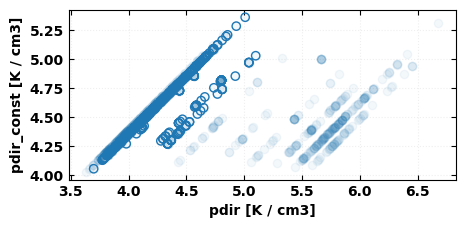

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.set_aspect('equal')
axs.scatter(pdir, pdir_const, fc='C0', ec='C0', alpha=0.05)
axs.scatter(pdir[mask_age], pdir_const[mask_age], fc='none', ec='C0', alpha=1)

axs.set_xlabel('pdir [%s]' %pdir.unit)
axs.set_ylabel('pdir_const [%s]' %pdir_const.unit)
axs.grid(True)

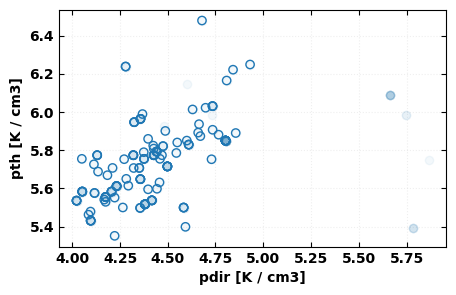

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.set_aspect('equal')
axs.scatter(pdir, pth, fc='C0', ec='C0', alpha=0.05)
axs.scatter(pdir[mask_age], pth[mask_age], fc='none', ec='C0', alpha=1)

axs.set_xlabel('pdir [%s]' %pdir.unit)
axs.set_ylabel('pth [%s]' %pdir_const.unit)
axs.grid(True)

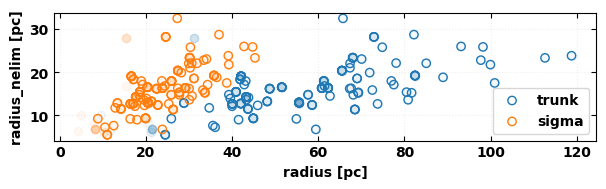

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(7, 7))
axs.set_aspect('equal')
axs.scatter(radius, radius_nelim, fc='C0', ec='C0', alpha=0.05)
axs.scatter(radius[mask_age], radius_nelim[mask_age], fc='none', ec='C0', alpha=1, label='trunk')

axs.scatter(radius_sigma, radius_nelim, fc='C1', ec='C1', alpha=0.05)
axs.scatter(radius_sigma[mask_age], radius_nelim[mask_age], fc='none', ec='C1', alpha=1, label='sigma')

axs.set_xlabel('radius [%s]' %radius.unit)
axs.set_ylabel('radius_nelim [%s]' %radius_nelim.unit)
axs.grid(True)
axs.legend()

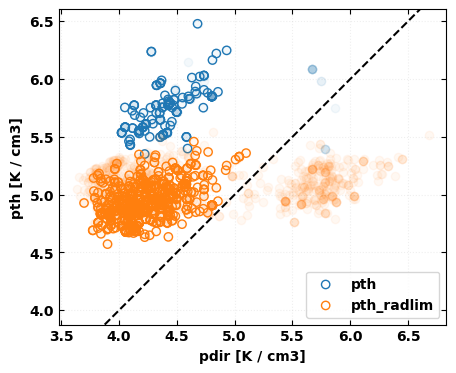

In [9]:
age = props_all['reg_dolflux_Age_MinChiSq'].quantity.to('Myr')
mask_age = age<5*au.Myr

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.set_aspect('equal')

axs.scatter(pdir, pth, fc='C0', ec='C0', alpha=0.05)
axs.scatter(pdir[mask_age], pth[mask_age], fc='none', ec='C0', alpha=1, label='pth')

axs.scatter(pdir, pth_radlim, fc='C1', ec='C1', alpha=0.05)
axs.scatter(pdir[mask_age], pth_radlim[mask_age], fc='none', ec='C1', alpha=1,label='pth_radlim')
axs.axline((4,4), slope=1, c='k', ls='--')

axs.set_xlabel('pdir [%s]' %pdir.unit)
axs.set_ylabel('pth [%s]' %pdir_const.unit)
axs.grid(True)
axs.legend()

In [10]:
# pth[mask_age][~pth[mask_age].mask]

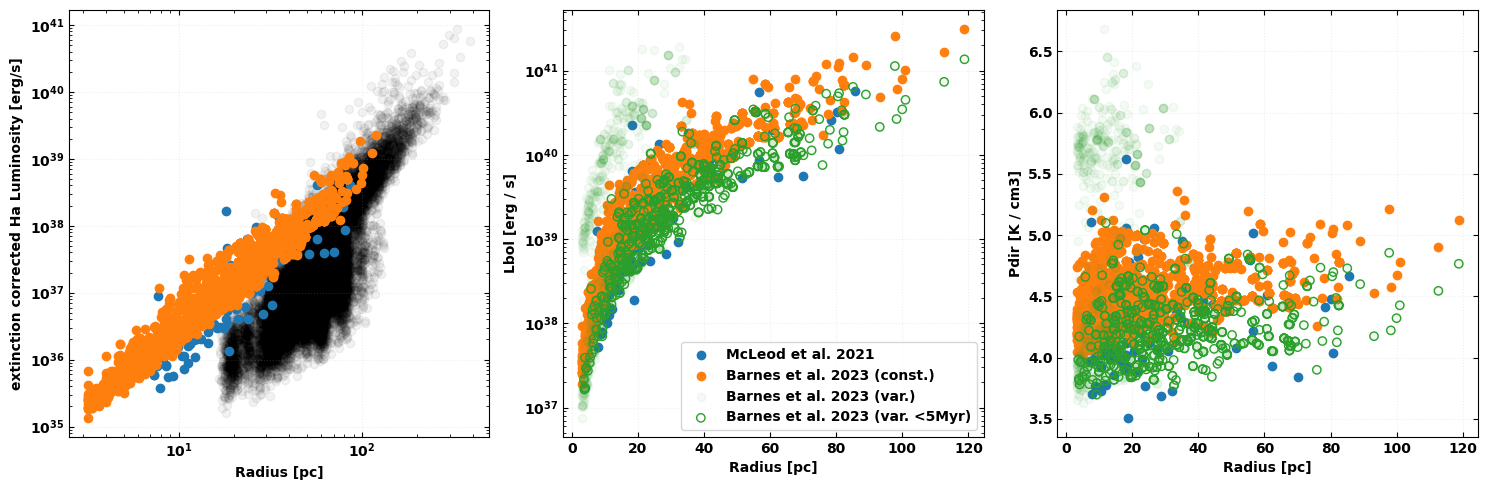

In [11]:
import matplotlib.pyplot as plt

def get_lbol(pdir, radius):
    """Convert direct radiation pressure to bolometric luminosity"""
    lbol = (pdir * ac.k_B * 4 * np.pi * (radius.to('cm') ** 2) * ac.c.to('cm/s')) / 3
    return lbol.to('Lsun')



# Create a figure with four subplots in two rows
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Second subplot
axs[0].scatter(t_mcload21['radius'], get_lbol(10**(t_mcload21['pdir'].quantity.value) * pdir.unit, t_mcload21['radius']).to('erg/s')/138.0, label='McLeod et al. 2021', c='C0')
axs[0].scatter(t_barnes21_nomask['reff_pc'], t_barnes21_nomask['ha_lum'].to('erg/s'),  c='black', alpha=0.05, zorder=-1)
axs[0].scatter(t_barnes21_nomask['reff_pc'][0], t_barnes21_nomask['ha_lum'].to('erg/s')[0],  c='black', label='Barnes et al. 2021', alpha=0.5, zorder=-1)
axs[0].scatter(props_all['radius_trunkclose_pc'], props_all['ha_lum_hst'].to('erg/s'), label='Barnes et al. 2023', c='C1')


axs[0].set_ylabel('extinction corrected Ha Luminosity [erg/s]')
axs[0].set_xlabel('Radius [pc]')
axs[0].set_yscale('log')
axs[0].set_xscale('log')

# Third subplot
axs[1].scatter(t_mcload21['radius'], get_lbol(10**(t_mcload21['pdir'].quantity.value) * pdir.unit, t_mcload21['radius']).to('erg/s'), label='McLeod et al. 2021', c='C0')
axs[1].scatter(props_all['radius_trunkclose_pc'], props_all['lbol_const'], label='Barnes et al. 2023 (const.)', c='C1')
axs[1].scatter(props_all['radius_trunkclose_pc'], props_all['lbol'], label='Barnes et al. 2023 (var.)', c='C2', alpha=0.05)
axs[1].scatter(props_all['radius_trunkclose_pc'][mask_age], props_all['lbol'][mask_age], label='Barnes et al. 2023 (var. <5Myr)', fc='none', ec='C2', alpha=1)

axs[1].set_ylabel('Lbol [%s]' %props_all['lbol_const'].unit)
axs[1].set_yscale('log')
axs[1].set_xlabel('Radius [pc]')
# axs[2].legend()

# Fourth subplot
axs[2].scatter(t_mcload21['radius'], t_mcload21['pdir'], label='McLeod et al. 2021', c='C0')
axs[2].scatter(props_all['radius_trunkclose_pc'], props_all['pdir_const'], label='Barnes et al. 2023 (const.)', c='C1')
axs[2].scatter(props_all['radius_trunkclose_pc'], props_all['pdir'], label='Barnes et al. 2023 (var.)', c='C2', alpha=0.05)
axs[2].scatter(props_all['radius_trunkclose_pc'][mask_age], props_all['pdir'][mask_age], label='Barnes et al. 2023 (var. <5Myr)', fc='none', ec='C2', alpha=1)


axs[2].set_xlabel('Radius [pc]')
axs[2].set_ylabel('Pdir [%s]' %t_mcload21['pdir'].unit)
# axs[3].legend()

axs[0].grid()
axs[1].grid()
axs[2].grid()

axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [ ]:
plt.scatter(t_barnes21['ha_lum'].to('dex(erg/s)'), t_barnes21['pdir_min'], c='black', label='Barnes et al. 2021 (MIN)', alpha=0.2)
plt.scatter(t_barnes21['ha_lum'].to('dex(erg/s)'), t_barnes21['pdir_max'], c='grey', label='Barnes et al. 2021 (MAX)', alpha=0.2)

plt.scatter(np.log10(get_lbol(10**(t_mcload21['pdir'].quantity.value) * pdir.unit, t_mcload21['radius']).to('erg/s').value/138.0), t_mcload21['pdir'], label='McLeod et al. 2021', c='C0')
# plt.scatter(props_all['ha_lum_hst'].to('dex(erg/s)'), props_all['pdir'], label='Barnes et al. 2023', c='C1')
plt.scatter(props_all['ha_lum_hst'].to('dex(erg/s)'), props_all['pdir_const'], label='Barnes et al. 2023', c='C1')

plt.xlabel(r'L$_\mathrm{H\alpha}$ (ext. corr.) [log(erg/s)]')
plt.ylabel(r'P$_\mathrm{dir}$ [log(%s)]' %t_mcload21['pdir'].unit)
plt.legend(loc='lower right')